<a href="https://colab.research.google.com/github/dpcoolmufa/Dog_Breed_Indentification/blob/master/Dog_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multiclass Dog Breed CLassification
this notebook builds a multi-class classifier to identify dog breeds

## 1. Problem
Identifying the breed of a dog given an image of adog

## 2. Data
the data we're using is from Kaggle's dog breed identification competition

url: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog on each test image.

## 4. Features

Some information about Data:
* we're dealing with images 
* there are 120 breeds of dogs
* There are around 10,000+ in training set
* there are around 10,000+ in test set

In [ ]:
#unzip the uploaded in google drive
#!unzip "drive/My Drive/Data/dog-breed-identification.zip" -d "drive/My Drive/Data"

# Get our workspace

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

#check for gpu
print("GPU","Available" if tf.config.list_logical_devices("GPU") else "not available")

GPU Available


## Gettin our data ready (turning into tensors)


In [ ]:
import pandas as pd
labels=pd.read_csv("drive/My Drive/Data/labels.csv")
labels.head()


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

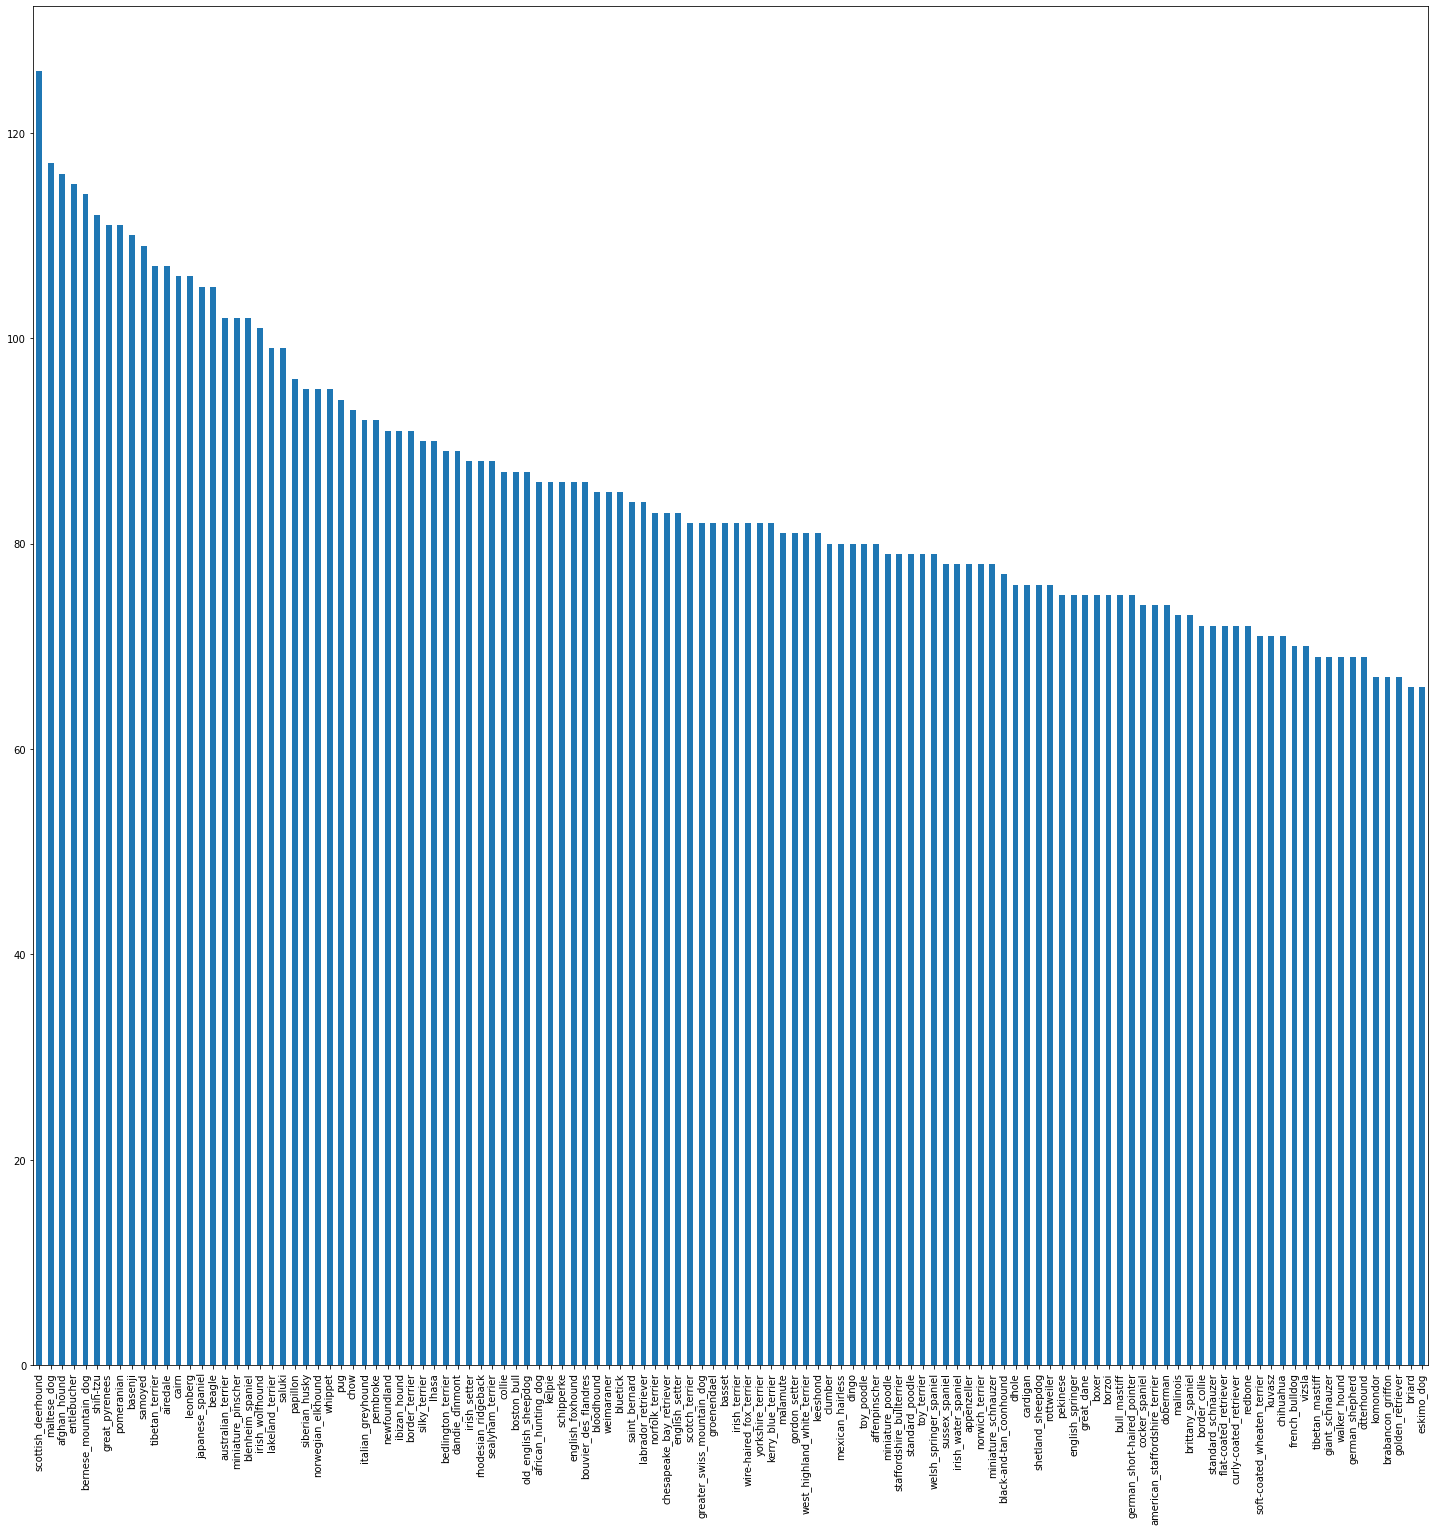

In [ ]:
labels["breed"].value_counts().plot.bar(figsize=(25,25))

In [ ]:
labels["breed"].value_counts().median()


82.0

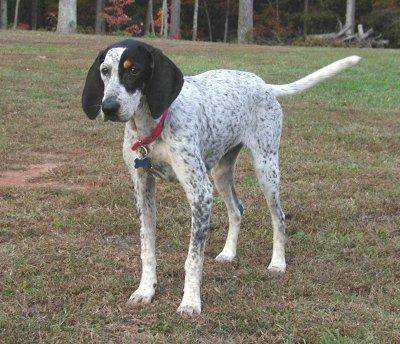

In [ ]:
# Viewing an image
from IPython.display import Image
Image("drive/My Drive/Data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels

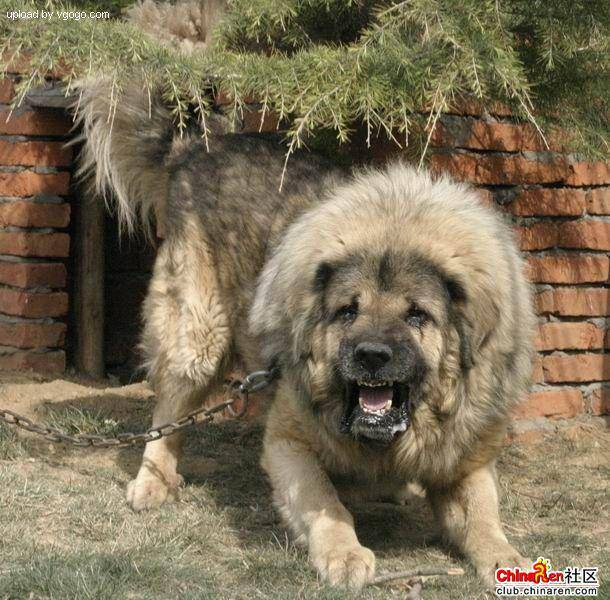

In [ ]:
f_names=["drive/My Drive/Data/train/"+fname+".jpg" for fname in labels["id"]]
Image(f_names[9000])


In [ ]:
import os
if len(os.listdir("drive/My Drive/Data/train"))==len(f_names):
  print("Proceed")
else:
  print("Check the target directory")

Proceed


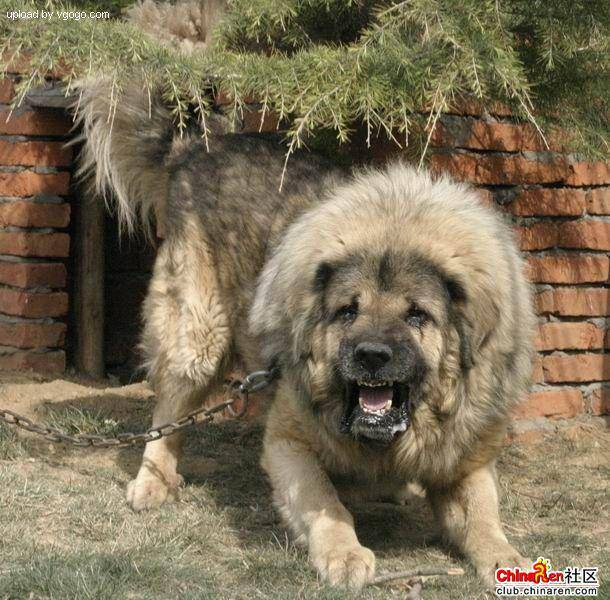

In [ ]:
Image(f_names[9000])

In [ ]:
labels["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, prepare labels

In [ ]:
import numpy as np
names=labels["breed"].to_numpy()

names

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
if len(names)==len(f_names):
  print("number of labels matches number of filenames")
else:
  print("mismatch between labels and filenames")

number of labels matches number of filenames


In [ ]:
# Find the unique values
unique_breeds=np.unique(names)
len(unique_breeds)

120

In [ ]:
# Turn every label into a boolean array
boolean_labels=[label== unique_breeds for label in names]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own validation set

In [ ]:
# Setup x and y
X=f_names
y=boolean_labels
len(X),len(y)

(10222, 10222)

We're going to start off with sample of data(1000)

In [ ]:
# set number of images
NUM_IMAGES=1000 #@param {type:"slider",min:1000,max:10000}

In [ ]:
# Split data into train and split

from sklearn.model_selection import train_test_split

#split the data into training and validation of total size NUM_IMAGES

X_train,X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],
                                             y[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42)


In [ ]:
X_train[:5], y_train[:2]

(['drive/My Drive/Data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fa

## Preprocessing images (turning images into Tensors)

In [ ]:
from matplotlib.pyplot import imread

IMG_SIZE=224
# function for preprocessing images
def preprocess_image(file_path,img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a tensor
  """
  image=tf.io.read_file(file_path)
  #turn the jpeg image into numerical tensor with 3 colour channels
  image=tf.image.decode_jpeg(image,channels=3)
  #convert the colour channel values too from 0-255 to 0-1 values
  image=tf.image.convert_image_dtype(image,tf.float32)
  #Resize the image to our desired value
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

## Turning our data into batches 

In [ ]:
# Function to return a tuple (image,label)
def get_image_label(image_path,label):
  image=preprocess_image(image_path)
  return image,label

In [ ]:
(preprocess_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

##### Function to create batches

In [ ]:
BATCH_SIZE=32

# Function to turn data into Batches

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  if test_data:
    print("Creating test data batches....")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch=data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating validation data batches....")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                             tf.constant(y)))
    data_batch=data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creating training data batches....")

    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                             tf.constant(y)))
    
    data=data.shuffle(buffer_size=len(X))

    data=data.map(get_image_label)

    data_batch=data.batch(BATCH_SIZE)
  return data_batch
  

In [ ]:
train_data = create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches....
Creating validation data batches....


In [ ]:
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [ ]:
import matplotlib.pyplot as plt

# Function for viewing images in a data batch
def show_30_images(images,labels):
  """
  Displays a plot of 30 images and their labels from data batch
  """
  plt.figure(figsize=(10,10))

  for i in range(30):
    ax=plt.subplot(6,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [ ]:
train_images,train_labels=next(train_data.as_numpy_iterator())
train_images,train_labels

(array([[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.0000

In [ ]:
unique_breeds[y[0].argmax()]

'boston_bull'

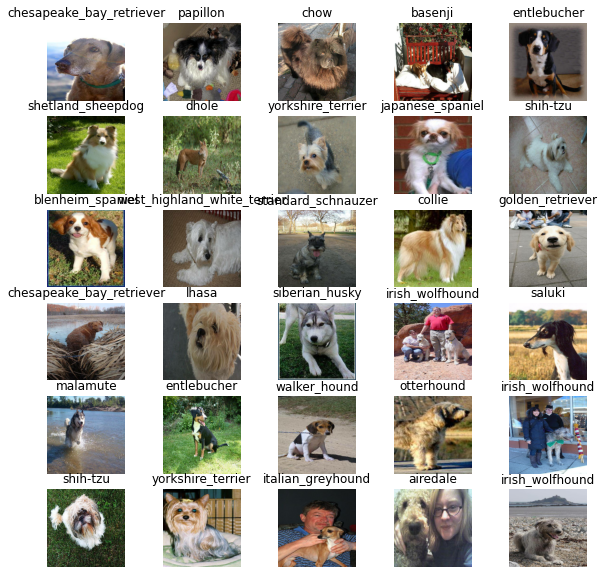

In [ ]:
show_30_images(train_images,train_labels)

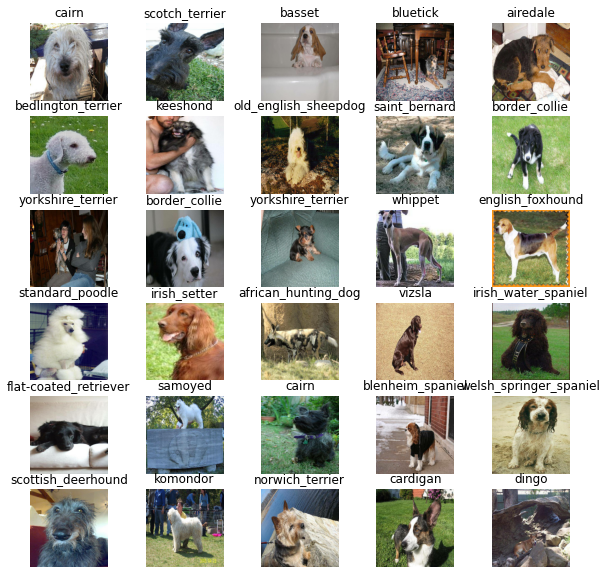

In [ ]:
val_images,val_labels=next(val_data.as_numpy_iterator())
show_30_images(val_images,val_labels)

## Build a Model 

In [ ]:
# setup input shape to the model
INPUT_SHAPE=[None, IMG_SIZE, IMG_SIZE, 3]

OUTPUT_SHAPE=len(unique_breeds)

MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
# function to build a keras model 
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):

  model=tf.keras.Sequential([
                             hub.KerasLayer(MODEL_URL),
                             tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                   activation="softmax")
                            ])
  
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  model.build(INPUT_SHAPE)

  return model

In [ ]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
#Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Function to build a Tensorboard callback
def create_tensorboard_log():

  logdir=os.path.join("drive/My Drive/Data/logs",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3)

## training a model(on subset of data)

In [ ]:
NUM_EPOCHS=100 #@param {type:"slider",min:10,max:100,step:10}

In [ ]:
# Function to train and return a trained model

def train_model():
  model=create_model()

  tensorboard=create_tensorboard_log()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  return model

In [ ]:
model=train_model()

Epoch 1/100
25/25 [==============================] - 525s 21s/step - loss: 4.3969 - accuracy: 0.1200 - val_loss: 3.5342 - val_accuracy: 0.2400
Epoch 2/100
25/25 [==============================] - 5s 197ms/step - loss: 1.5555 - accuracy: 0.6850 - val_loss: 2.2985 - val_accuracy: 0.4750
Epoch 3/100
25/25 [==============================] - 5s 197ms/step - loss: 0.5290 - accuracy: 0.9362 - val_loss: 1.7861 - val_accuracy: 0.5550
Epoch 4/100
25/25 [==============================] - 5s 198ms/step - loss: 0.2406 - accuracy: 0.9875 - val_loss: 1.5840 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 5s 195ms/step - loss: 0.1418 - accuracy: 0.9962 - val_loss: 1.5192 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 5s 197ms/step - loss: 0.0969 - accuracy: 1.0000 - val_loss: 1.4634 - val_accuracy: 0.6300
Epoch 7/100
25/25 [==============================] - 5s 197ms/step - loss: 0.0729 - accuracy: 1.0000 - val_loss: 1.4377 - val_accuracy: 0.6450

### Checking the  Tensorboard logs

In [ ]:
%tensorboard --logdir drive/My\ Drive/Data/logs

<IPython.core.display.Javascript object>

In [ ]:
# Making Predictions
predictions=model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 126ms/step


array([[2.78135855e-03, 4.89187732e-05, 2.63848691e-03, ...,
        1.12924507e-04, 7.13108529e-05, 8.55372578e-04],
       [4.02153266e-04, 2.27007244e-04, 5.22277260e-04, ...,
        3.03169043e-04, 2.76354083e-04, 2.11428105e-05],
       [3.52035859e-05, 2.15325763e-05, 6.87817301e-05, ...,
        4.00509089e-05, 3.82913422e-05, 1.09179667e-03],
       ...,
       [5.30149782e-06, 2.03415057e-05, 4.59733819e-05, ...,
        7.64801553e-06, 5.59778091e-05, 2.61989426e-05],
       [8.82092514e-04, 1.08977867e-04, 1.08105975e-04, ...,
        4.07897169e-05, 1.79475537e-05, 6.77922415e-03],
       [1.88838312e-04, 8.20740970e-05, 7.12424691e-04, ...,
        9.73187503e-04, 8.39079323e-04, 9.88073316e-06]], dtype=float32)

In [ ]:
index=120
print(predictions[index])
print(f'Max value(probability of prediction:{np.max(predictions[index])}')

print(f"sum :{np.sum(predictions[index])}")
print(f"Max Index:{np.argmax(predictions[index])}")
print(f'predicted label:{unique_breeds[np.argmax(predictions[index])]}')

[3.6635832e-03 8.8170207e-05 1.5297304e-03 1.8820132e-05 4.2964257e-03
 6.4888847e-04 4.6678082e-04 2.9503342e-03 3.7823129e-02 3.7185022e-01
 8.4319276e-05 3.5015208e-04 1.6313856e-03 1.4635035e-02 1.2222269e-02
 1.5941600e-03 7.1815375e-05 1.8364495e-03 5.1904545e-04 5.5172615e-04
 2.9718198e-04 6.7953891e-03 2.2676541e-04 3.0095316e-04 4.8655691e-03
 1.6215608e-03 3.4254239e-04 8.0737419e-04 3.9479402e-03 3.7274405e-04
 4.4226341e-04 7.2673941e-04 4.1976298e-04 2.2507561e-04 4.1622337e-04
 3.4301475e-04 2.1609258e-04 8.2213385e-04 6.0646312e-04 2.0033050e-01
 2.0692969e-04 2.4896616e-04 5.3263724e-02 9.6550910e-04 7.3097111e-03
 1.4257098e-04 3.8394518e-04 3.4035286e-03 4.9010137e-05 8.4143812e-03
 1.0657167e-04 6.6328800e-04 5.5339215e-03 2.0066449e-02 1.3419539e-04
 1.4309842e-03 2.7133911e-04 4.8937462e-04 1.2022936e-04 2.0407244e-04
 1.6055352e-03 1.9147873e-03 1.2456917e-05 1.0058097e-04 2.5720135e-04
 2.1907112e-03 8.5345801e-04 1.3066425e-02 1.0823460e-03 7.8916717e-05
 5.710

In [ ]:
#Turn probablities into their respective labels
def get_pred_label(prediction_probabilities):
  """
  Turning pred_probs into their true labels
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

  

In [ ]:
#Function to unbatch elements

def unbatch_data(data):
  images=[]
  labels=[]
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images,labels

val_images,val_labels=unbatch_data(val_data)

##visualizing the data 

In [ ]:
def plot_pred(pred_probs,labels,images,n=1):

  pred_prob,true_label,image= pred_probs[n],labels[n],images[n]

  pred_label=get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  if pred_label== true_label:
    color="green"
  else:
    color="red"

  plt.title("{} {:0.2f}% {}".format(pred_label,
                                  np.max(pred_prob)*100,
                                  true_label),color=color)


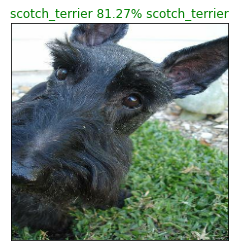

In [ ]:
plot_pred(pred_probs=predictions,
         labels=val_labels,
         images=val_images,
          )

In [ ]:
def plot_pred_conf(pred_probs,labels,n=1):

  pred_prob,true_label=pred_probs[n],labels[n]

  pred_label=get_pred_label(pred_prob)

  top_pred_index=pred_prob.argsort()[-10:][::-1]

  top_pred_values=pred_prob[top_pred_index] 

  top_pred_labels=unique_breeds[top_pred_index]

  top_plot=plt.bar(np.arange(len(top_pred_labels)),
                   top_pred_values,
                   color="grey",
                   )
  plt.xticks(np.arange(len(top_pred_labels)),
                   labels=top_pred_labels,
                   rotation="vertical")
  
  if np.isin(true_label,top_pred_labels):
    top_plot[np.argmax(top_pred_labels==true_label)].set_color("green")
  else:
    pass

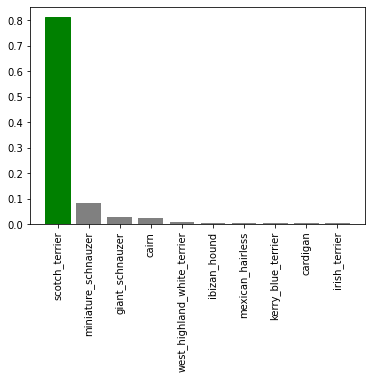

In [ ]:

plot_pred_conf(pred_probs=predictions,
               labels=val_labels,
               )

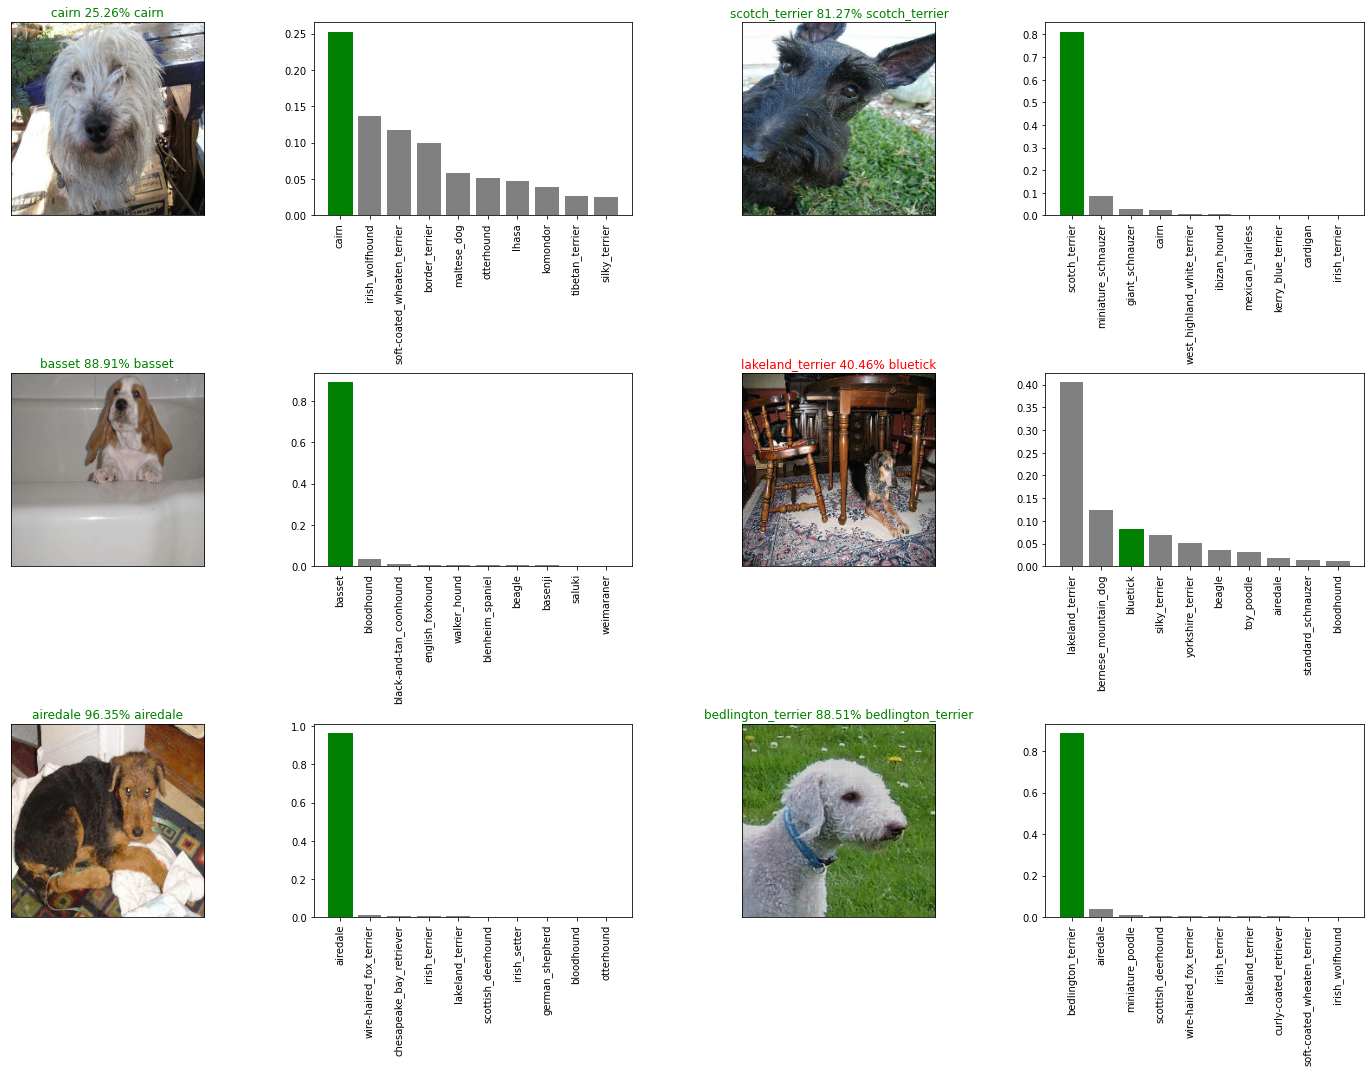

In [ ]:
# Testing few prediction
i_multiplier=0
num_rows=3
num_cols=2
num_images=num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows,2*num_cols,2*i+1)
  plot_pred(pred_probs=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows,2*num_cols,2*i+2)
  plot_pred_conf(pred_probs=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)  
plt.show()

## Saving and reloading a model

In [ ]:
def save_model(model,suffix=None):
  """
  Saves a model in models directory and appends a suffix
  """
  modeldir =os.path.join("drive/My Drive/Data/models",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path=modeldir +"-"+suffix+".h5"
  print(f"Saving model to:{model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
##Load model
def load_model(model_path):
  """
  Loads a model from a specified directory
  """
  print(f"Loading saved model from:{model_path}")
  model=tf.keras.models.load_model(model_path,
                                   custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(model,suffix="trainedOn-1000-images")

Saving model to:drive/My Drive/Data/models/20200725-100735-trainedOn-1000-images.h5...


'drive/My Drive/Data/models/20200725-100735-trainedOn-1000-images.h5'

In [ ]:
# load trained model
loaded_model1000=load_model("drive/My Drive/Data/models/20200725-100735-trainedOn-1000-images.h5")

Loading saved model from:drive/My Drive/Data/models/20200725-100735-trainedOn-1000-images.h5


In [ ]:
loaded_model1000.evaluate(val_data)

7/7 [==============================] - 1s 115ms/step - loss: 1.3515 - accuracy: 0.6450


[1.3514899015426636, 0.6449999809265137]

In [ ]:
model.evaluate(val_data)

7/7 [==============================] - 1s 124ms/step - loss: 1.3515 - accuracy: 0.6450


[1.3514899015426636, 0.6449999809265137]

In [ ]:
#createing a data batch with the full data set
full_data=create_data_batches(X,y)

Creating training data batches....


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
#create a model
full_model=create_model()

In [ ]:
# create full model callbacks
full_model_tensorboard=create_tensorboard_log()

full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                           patience=3)

## Full Model fitting

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 5595s 17s/step - loss: 1.3622 - accuracy: 0.6695
Epoch 2/100
320/320 [==============================] - 51s 160ms/step - loss: 0.4062 - accuracy: 0.8782
Epoch 3/100
320/320 [==============================] - 50s 155ms/step - loss: 0.2369 - accuracy: 0.9374
Epoch 4/100
320/320 [==============================] - 49s 154ms/step - loss: 0.1547 - accuracy: 0.9642
Epoch 5/100
320/320 [==============================] - 51s 161ms/step - loss: 0.1095 - accuracy: 0.9775
Epoch 6/100
320/320 [==============================] - 53s 165ms/step - loss: 0.0775 - accuracy: 0.9870
Epoch 7/100
320/320 [==============================] - 53s 166ms/step - loss: 0.0595 - accuracy: 0.9907
Epoch 8/100
320/320 [==============================] - 52s 162ms/step - loss: 0.0473 - accuracy: 0.9933
Epoch 9/100
320/320 [==============================] - 52s 164ms/step - loss: 0.0390 - accuracy: 0.9958
Epoch 10/100
320/320 [==============================] - 53s 164m

In [ ]:
save_model(full_model,suffix="fully-trained-model")

Saving model to:drive/My Drive/Data/models/20200725-121749-fully-trained-model.h5...


'drive/My Drive/Data/models/20200725-121749-fully-trained-model.h5'

In [ ]:
load_full_model=load_model("drive/My Drive/Data/models/20200725-121749-fully-trained-model.h5")

Loading saved model from:drive/My Drive/Data/models/20200725-121749-fully-trained-model.h5


## Making Predictions on test data

In [ ]:
test_path="drive/My Drive/Data/test/"
test_filenames=[test_path+fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Data/test/ed8e5c431d6539db02614ddc1f35ce10.jpg',
 'drive/My Drive/Data/test/ee3b0ea1f7649dbc3a5724ebccdff863.jpg',
 'drive/My Drive/Data/test/f02b0bb575f8dd86c63ab38df20483ba.jpg',
 'drive/My Drive/Data/test/f16fd3afeb123e25cfe3e712faee8aa5.jpg',
 'drive/My Drive/Data/test/ed306448d7f19d3e5cfd7b446898cd44.jpg',
 'drive/My Drive/Data/test/e995cac3e30ce4e55d0f203c20cd0986.jpg',
 'drive/My Drive/Data/test/e89d149b27db1f144ca122bb29b8ab9f.jpg',
 'drive/My Drive/Data/test/e995cbf5f2c4da27a1e56966c70de380.jpg',
 'drive/My Drive/Data/test/f47e4614a5d7d190cf95b4b9c1e78576.jpg',
 'drive/My Drive/Data/test/ef0ec3c95160918de7bd290897ea9f65.jpg']

In [ ]:
len(test_filenames)

10357

In [ ]:
test_data=create_data_batches(test_filenames,test_data=True)

Creating test data batches....


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
test_predictions=load_full_model.predict(test_data,verbose=1)

324/324 [==============================] - 6393s 20s/step


In [ ]:
test_predictions[:10]

array([[8.1222362e-09, 2.6627571e-08, 1.6593009e-09, ..., 2.3470832e-07,
        1.4278528e-07, 1.9502758e-07],
       [1.0576124e-06, 1.0806635e-05, 1.7142408e-07, ..., 2.2487138e-05,
        4.0422085e-10, 5.3197009e-06],
       [4.7339445e-11, 5.2265636e-11, 8.9714841e-10, ..., 5.6511174e-09,
        1.7594468e-11, 6.1637467e-10],
       ...,
       [4.0244527e-10, 4.0271900e-12, 9.6818338e-11, ..., 3.1014752e-13,
        1.5333517e-09, 1.3796093e-09],
       [3.8963721e-10, 5.3632682e-08, 5.2197224e-10, ..., 1.9337510e-06,
        7.4309274e-03, 2.0477723e-06],
       [1.4497155e-08, 4.7790596e-05, 1.4815228e-09, ..., 4.9266205e-03,
        9.8094347e-07, 2.5005338e-09]], dtype=float32)

In [ ]:
np.savetxt("drive/My Drive/Data/preds_array.csv",test_predictions,delimiter=",")

In [ ]:
test_predictions.shape

(10357, 120)

In [ ]:
preds_df=pd.DataFrame(columns=["id"]+list(unique_breeds))
test_ids=[os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"]=test_ids
preds_df.head()

id  ... yorkshire_terrier
0  ed8e5c431d6539db02614ddc1f35ce10  ...               NaN
1  ee3b0ea1f7649dbc3a5724ebccdff863  ...               NaN
2  f02b0bb575f8dd86c63ab38df20483ba  ...               NaN
3  f16fd3afeb123e25cfe3e712faee8aa5  ...               NaN
4  ed306448d7f19d3e5cfd7b446898cd44  ...               NaN

[5 rows x 121 columns]

In [ ]:
preds_df[list(unique_breeds)]=test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  ed8e5c431d6539db02614ddc1f35ce10  ...       1.95028e-07
1  ee3b0ea1f7649dbc3a5724ebccdff863  ...        5.3197e-06
2  f02b0bb575f8dd86c63ab38df20483ba  ...       6.16375e-10
3  f16fd3afeb123e25cfe3e712faee8aa5  ...       1.45367e-05
4  ed306448d7f19d3e5cfd7b446898cd44  ...       2.82888e-10

[5 rows x 121 columns]

In [ ]:
preds_df.to_csv("drive/My Drive/Data/Dog-Detection-Model.csv",index=False)